<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Check-your-sample-table-(i.e.-metadata-file)" data-toc-modified-id="Check-your-sample-table-(i.e.-metadata-file)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Check your sample table (i.e. metadata file)</a></span></li><li><span><a href="#Check-your-TRN" data-toc-modified-id="Check-your-TRN-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check your TRN</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load the data</a></span></li></ul></li><li><span><a href="#Regulatory-iModulons" data-toc-modified-id="Regulatory-iModulons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regulatory iModulons</a></span></li><li><span><a href="#Functional-iModulons" data-toc-modified-id="Functional-iModulons-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Functional iModulons</a></span><ul class="toc-item"><li><span><a href="#GO-Enrichments" data-toc-modified-id="GO-Enrichments-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>GO Enrichments</a></span></li><li><span><a href="#KEGG-Enrichments" data-toc-modified-id="KEGG-Enrichments-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>KEGG Enrichments</a></span><ul class="toc-item"><li><span><a href="#Load-KEGG-mapping" data-toc-modified-id="Load-KEGG-mapping-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Load KEGG mapping</a></span></li><li><span><a href="#Perform-enrichment" data-toc-modified-id="Perform-enrichment-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Perform enrichment</a></span></li><li><span><a href="#Convert-KEGG-IDs-to-human-readable-names" data-toc-modified-id="Convert-KEGG-IDs-to-human-readable-names-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Convert KEGG IDs to human-readable names</a></span></li><li><span><a href="#Save-files" data-toc-modified-id="Save-files-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Save files</a></span></li></ul></li></ul></li><li><span><a href="#Check-for-single-gene-iModulons" data-toc-modified-id="Check-for-single-gene-iModulons-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check for single gene iModulons</a></span></li><li><span><a href="#Examine-global-activity-correlations" data-toc-modified-id="Examine-global-activity-correlations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Examine global activity correlations</a></span></li><li><span><a href="#Use-metadata-to-automatically-characterize-iModulons" data-toc-modified-id="Use-metadata-to-automatically-characterize-iModulons-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Use metadata to automatically characterize iModulons</a></span></li><li><span><a href="#Compare-against-published-iModulons" data-toc-modified-id="Compare-against-published-iModulons-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Compare against published iModulons</a></span><ul class="toc-item"><li><span><a href="#Visualize-linked-iModulons" data-toc-modified-id="Visualize-linked-iModulons-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Visualize linked iModulons</a></span></li></ul></li><li><span><a href="#Save-iModulon-object" data-toc-modified-id="Save-iModulon-object-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Save iModulon object</a></span></li><li><span><a href="#Coming-soon" data-toc-modified-id="Coming-soon-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Coming soon</a></span></li></ul></div>

# Setup
This IPython notebook will walk through the steps of characterizing iModulons through semi-automated tools. You will need:
* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

Optional:
* iModulon table (if you already have some characterized iModulons)

In [1]:
from pymodulon.core import IcaData
from pymodulon.plotting import *
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm

In [2]:
# Enter the location of your data here
data_dir = '../example_data/modulome_example/data/'

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [3]:
df_metadata = pd.read_csv(path.join(data_dir,'sample_table.csv'),index_col=0)
df_metadata[['project','condition']].head()

,project,condition
SRX3467357,FadR,wt_p
SRX3467358,FadR,wt_p
SRX3467359,FadR,ko_p
SRX3467360,FadR,ko_p
SRX3565164,GDGT,75_2.4_log


In [4]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## Check your TRN

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [5]:
df_trn = pd.read_csv(path.join(data_dir,'TRN.tsv'),sep='\t')
df_trn.head()

,regulator,gene_id,regulator_id,gene_name,old_locus_tag,gene_issue,other_id,direction,evidence,PMID,Additional Notes
0,BarR,SACI_RS10330,SACI_RS10330,barR,Saci_2136,NaN,3472865,NaN,qRT-PCR,24646198,BarR TF (Lrp/AsnC family transcriptional regul...
1,BarR,SACI_RS10335,SACI_RS10330,NaN,Saci_2137,NaN,3472866,+,qRT-PCR,24646198,NaN
2,BarR,SACI_RS00130,SACI_RS10330,NaN,Saci_0028,NaN,3472576,NaN,"ChIP-Seq, qRT-PCR",27502941,NaN
3,BarR,SACI_RS00275,SACI_RS10330,meaB,Saci_0061,NaN,3472976,NaN,"ChIP-Seq, qRT-PCR",27502941,NaN
4,BarR,SACI_RS03305,SACI_RS10330,infB,Saci_0695,NaN,3472541,NaN,"ChIP-Seq, qRT-PCR",27502941,NaN


The `regulator` and `gene_id` must be filled in for each row

In [6]:
print(df_trn.regulator.notnull().all())
print(df_trn.gene_id.notnull().all())

True
True


## Load the data
You're now ready to load your IcaData object!

In [7]:
ica_data = IcaData(M = path.join(data_dir,'M.csv'),
                   A = path.join(data_dir,'A.csv'),
                   X = path.join(data_dir,'X.csv'),
                   gene_table = path.join(data_dir,'gene_table.csv'),
                   sample_table = path.join(data_dir,'sample_table.csv'),
                   trn = path.join(data_dir,'TRN.tsv'))

If you don't have a TRN (or have a very minimal TRN), use `threshold_method = 'kmeans'`

In [8]:
ica_data = IcaData(M = path.join(data_dir,'M.csv'),
                   A = path.join(data_dir,'A.csv'),
                   X = path.join(data_dir,'X.csv'),
                   gene_table = path.join(data_dir,'gene_table.csv'),
                   sample_table = path.join(data_dir,'sample_table.csv'),
                   trn = path.join(data_dir,'TRN.tsv'),
                   threshold_method = 'kmeans')

# Regulatory iModulons
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.

In [9]:
ica_data.compute_trn_enrichment()

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,4,ArnR;ArnR1,8.720300e-21,1.744060e-20,0.727273,1.000,0.842105,8.0,11.0,8.0,1.0
1,4,ArnA;ArnB,4.140730e-16,4.140730e-16,0.500000,0.875,0.636364,7.0,14.0,8.0,1.0
2,12,YtrA,2.933362e-09,5.866724e-09,0.400000,0.160,0.228571,8.0,20.0,50.0,1.0
3,26,FadR,6.388367e-14,1.277673e-13,0.526316,0.250,0.338983,10.0,19.0,40.0,1.0


You can also search for AND/OR combinations of regulators using the `max_regs` argument. Here, we see that iModulon #4 may be regulated by the both ArnR;ArnR1 and ArnA;ArnB.

In [10]:
ica_data.compute_trn_enrichment(max_regs=2)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,4,ArnR;ArnR1,8.720300e-21,3.836932e-19,0.727273,1.000,0.842105,8.0,11.0,8.0,1.0
1,4,ArnR;ArnR1+ArnA;ArnB,1.209743e-19,2.661436e-18,1.000000,0.875,0.933333,7.0,7.0,8.0,2.0
2,4,ArnR;ArnR1/ArnA;ArnB,2.312624e-18,3.391848e-17,0.444444,1.000,0.615385,8.0,18.0,8.0,2.0
3,4,ArnA;ArnB,4.140730e-16,4.554803e-15,0.500000,0.875,0.636364,7.0,14.0,8.0,1.0
4,12,YtrA,2.933362e-09,1.290679e-07,0.400000,0.160,0.228571,8.0,20.0,50.0,1.0
5,12,FadR/YtrA,6.764653e-08,1.488224e-06,0.230769,0.180,0.202247,9.0,39.0,50.0,2.0
6,26,FadR,6.388367e-14,2.810881e-12,0.526316,0.250,0.338983,10.0,19.0,40.0,1.0
7,26,BarR/FadR,1.227909e-11,2.701399e-10,0.344828,0.250,0.289855,10.0,29.0,40.0,2.0


Regulator enrichments can be directly saved to the `imodulon_table` using the `save` argument. This saves the enrichment with the lowest q-value to the table. For iModulon #4, it will automatically save `ArnR;ArnR1` as the enrichment, but we want to save `ArnR;ArnR1+ArnA;ArnB`. We can update our enrichments accordingly, using `compute_regulon_enrichment`:

In [11]:
ica_data.compute_trn_enrichment(max_regs=2,save=True)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,4,ArnR;ArnR1,8.720300e-21,3.836932e-19,0.727273,1.000,0.842105,8.0,11.0,8.0,1.0
1,4,ArnR;ArnR1+ArnA;ArnB,1.209743e-19,2.661436e-18,1.000000,0.875,0.933333,7.0,7.0,8.0,2.0
2,4,ArnR;ArnR1/ArnA;ArnB,2.312624e-18,3.391848e-17,0.444444,1.000,0.615385,8.0,18.0,8.0,2.0
3,4,ArnA;ArnB,4.140730e-16,4.554803e-15,0.500000,0.875,0.636364,7.0,14.0,8.0,1.0
4,12,YtrA,2.933362e-09,1.290679e-07,0.400000,0.160,0.228571,8.0,20.0,50.0,1.0
5,12,FadR/YtrA,6.764653e-08,1.488224e-06,0.230769,0.180,0.202247,9.0,39.0,50.0,2.0
6,26,FadR,6.388367e-14,2.810881e-12,0.526316,0.250,0.338983,10.0,19.0,40.0,1.0
7,26,BarR/FadR,1.227909e-11,2.701399e-10,0.344828,0.250,0.289855,10.0,29.0,40.0,2.0


In [12]:
ica_data.imodulon_table.head()

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ArnR;ArnR1,8.720300e-21,3.836932e-19,0.727273,1.0,0.842105,8.0,11.0,8.0,1.0


In [13]:
ica_data.compute_regulon_enrichment(4,'ArnR;ArnR1+ArnA;ArnB',save=True)

pvalue           1.209743e-19
precision        1.000000e+00
recall           8.750000e-01
f1score          9.333333e-01
TP               7.000000e+00
regulon_size     7.000000e+00
imodulon_size    8.000000e+00
n_regs           2.000000e+00
Name: ArnR;ArnR1+ArnA;ArnB, dtype: float64

In [14]:
ica_data.imodulon_table.head()

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ArnR;ArnR1+ArnA;ArnB,1.209743e-19,3.836932e-19,1.0,0.875,0.933333,7.0,7.0,8.0,2.0


You can rename iModulons in this jupyter notebook, or you can save the iModulon table as a CSV and edit it in Excel.

In [15]:
reg_entries = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
reg_entries

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
4,ArnR;ArnR1+ArnA;ArnB,1.209743e-19,3.836932e-19,1.000000,0.875,0.933333,7.0,7.0,8.0,2.0
12,YtrA,2.933362e-09,1.290679e-07,0.400000,0.160,0.228571,8.0,20.0,50.0,1.0
26,FadR,6.388367e-14,2.810881e-12,0.526316,0.250,0.338983,10.0,19.0,40.0,1.0


In [16]:
ica_data.rename_imodulons(reg_entries.regulator.to_dict())
print(ica_data.imodulon_names[:5])

[0, 1, 2, 3, 'ArnR;ArnR1+ArnA;ArnB']


You can also manually rename iModulons with long names

In [17]:
ica_data.rename_imodulons({'ArnR;ArnR1+ArnA;ArnB':'ArnRAB'})

In [18]:
ica_data.imodulon_names[:5]

[0, 1, 2, 3, 'ArnRAB']

# Functional iModulons

## GO Enrichments

The `GO_annotations.csv` file was created from `gene_annotation.ipynb`.

In [19]:
DF_GO = pd.read_csv(path.join(data_dir,'GO_annotations.csv'),index_col=0)
DF_GO.head()

,gene_id,gene_ontology
0,SACI_RS05325,glycerol kinase activity
1,SACI_RS05325,glycerol metabolic process
2,SACI_RS05525,maltose alpha-glucosidase activity
3,SACI_RS05590,protein binding
4,SACI_RS05600,identical protein binding


In [20]:
DF_GO.gene_id

0     SACI_RS05325
1     SACI_RS05325
2     SACI_RS05525
3     SACI_RS05590
4     SACI_RS05600
5     SACI_RS05610
6     SACI_RS08005
7     SACI_RS08005
8     SACI_RS09830
9     SACI_RS09830
10    SACI_RS10085
11    SACI_RS10085
12    SACI_RS10975
13    SACI_RS10975
14    SACI_RS10975
15    SACI_RS10980
16    SACI_RS10980
17    SACI_RS10980
18    SACI_RS10985
19    SACI_RS10985
20    SACI_RS10985
21    SACI_RS02915
22    SACI_RS00265
23    SACI_RS00265
24    SACI_RS00265
25    SACI_RS00265
26    SACI_RS00925
27    SACI_RS00925
28    SACI_RS00925
29    SACI_RS01090
30    SACI_RS01090
31    SACI_RS02225
32    SACI_RS10090
33    SACI_RS10090
34    SACI_RS00815
35    SACI_RS00815
Name: gene_id, dtype: object

In [21]:
DF_GO_enrich = ica_data.compute_annotation_enrichment(DF_GO,'gene_ontology')

In [22]:
DF_GO_enrich.to_csv(path.join(data_dir,'GO_enrichments.csv'))

## KEGG Enrichments

### Load KEGG mapping
The `kegg_mapping.csv` file was created from `gene_annotation.ipynb`. This contains KEGG orthologies, pathways, modules, and reactions. Only pathways and modules are relevant to iModulon characterization.

In [23]:
DF_KEGG = pd.read_csv(path.join(data_dir,'kegg_mapping.csv'),index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


,gene_id,database,kegg_id
1045,SACI_RS00040,KEGG_pathway,map00760
1046,SACI_RS00040,KEGG_pathway,map01100
1048,SACI_RS00060,KEGG_pathway,map00230
1050,SACI_RS00070,KEGG_pathway,map03410
1055,SACI_RS00085,KEGG_pathway,map00361


In [24]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

### Perform enrichment
Uses the `compute_annotation_enrichment` function

In [25]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [26]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,1,map00920,7.583891e-09,0.000001,0.444444,0.500000,0.470588,4.0,9.0,8.0
1,1,map01120,5.148720e-05,0.005071,0.033557,0.625000,0.063694,5.0,149.0,8.0
2,9,map00633,8.768797e-08,0.000017,1.000000,0.097561,0.177778,4.0,4.0,41.0
3,9,map00620,2.566049e-07,0.000025,0.200000,0.195122,0.197531,8.0,40.0,41.0
4,9,map00680,9.621038e-06,0.000632,0.200000,0.146341,0.169014,6.0,30.0,41.0


In [27]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,1,M00176,2.779658e-08,0.000005,1.000000,0.375000,0.545455,3.0,3.0,8.0
1,9,M00307,1.281569e-06,0.000218,0.666667,0.097561,0.170213,4.0,6.0,41.0
2,9,M00620,3.912129e-05,0.003325,0.333333,0.097561,0.150943,4.0,12.0,41.0
3,9,M00173,3.451772e-04,0.019560,0.200000,0.097561,0.131148,4.0,20.0,41.0
4,9,M00374,1.944239e-03,0.082630,0.129032,0.097561,0.111111,4.0,31.0,41.0


### Convert KEGG IDs to human-readable names

In [28]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    text = REST.kegg_find('pathway',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_pathway_enrich.loc[idx,'pathway_name'] = name
    except AttributeError:
        DF_pathway_enrich.loc[idx,'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    text = REST.kegg_find('module',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_module_enrich.loc[idx,'module_name'] = name
    except AttributeError:
        DF_module_enrich.loc[idx,'module_name'] = None

In [29]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,1,map00920,7.583891e-09,0.000001,0.444444,0.500000,0.470588,4.0,9.0,8.0,Sulfur metabolism
1,1,map01120,5.148720e-05,0.005071,0.033557,0.625000,0.063694,5.0,149.0,8.0,Microbial metabolism in diverse environments
2,9,map00633,8.768797e-08,0.000017,1.000000,0.097561,0.177778,4.0,4.0,41.0,Nitrotoluene degradation
3,9,map00620,2.566049e-07,0.000025,0.200000,0.195122,0.197531,8.0,40.0,41.0,Pyruvate metabolism
4,9,map00680,9.621038e-06,0.000632,0.200000,0.146341,0.169014,6.0,30.0,41.0,Methane metabolism


In [30]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,1,M00176,2.779658e-08,0.000005,1.000000,0.375000,0.545455,3.0,3.0,8.0,"Assimilatory sulfate reduction, sulfate => H2S"
1,9,M00307,1.281569e-06,0.000218,0.666667,0.097561,0.170213,4.0,6.0,41.0,"Pyruvate oxidation, pyruvate => acetyl-CoA"
2,9,M00620,3.912129e-05,0.003325,0.333333,0.097561,0.150943,4.0,12.0,41.0,"Incomplete reductive citrate cycle, acetyl-CoA..."
3,9,M00173,3.451772e-04,0.019560,0.200000,0.097561,0.131148,4.0,20.0,41.0,Reductive citrate cycle (Arnon-Buchanan cycle)
4,9,M00374,1.944239e-03,0.082630,0.129032,0.097561,0.111111,4.0,31.0,41.0,Dicarboxylate-hydroxybutyrate cycle


### Save files

In [31]:
DF_pathway_enrich.to_csv(path.join(data_dir,'kegg_pathway_enrichments.csv'))
DF_pathway_enrich.to_csv(path.join(data_dir,'kegg_module_enrichments.csv'))

# Check for single gene iModulons

In [32]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)

In [33]:
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'single_gene_'+str(i+1)})

In [34]:
ica_data.imodulon_names[:5]

[0, 1, 2, 'single_gene_1', 'ArnRAB']

# Examine global activity correlations

Mutual information can find more biologically relevant clusters than other correlation methods, so this is recommended. This identifies both linear correlations and non-linear correlations.

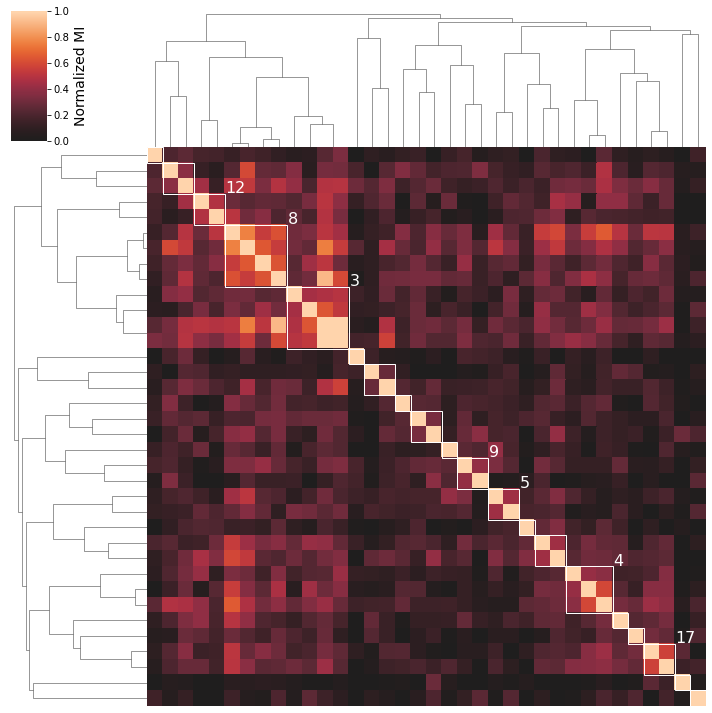

[AgglomerativeClustering(affinity='precomputed', compute_full_tree=True,
                         distance_threshold=0.9500000000000001,
                         linkage='complete', n_clusters=None)]

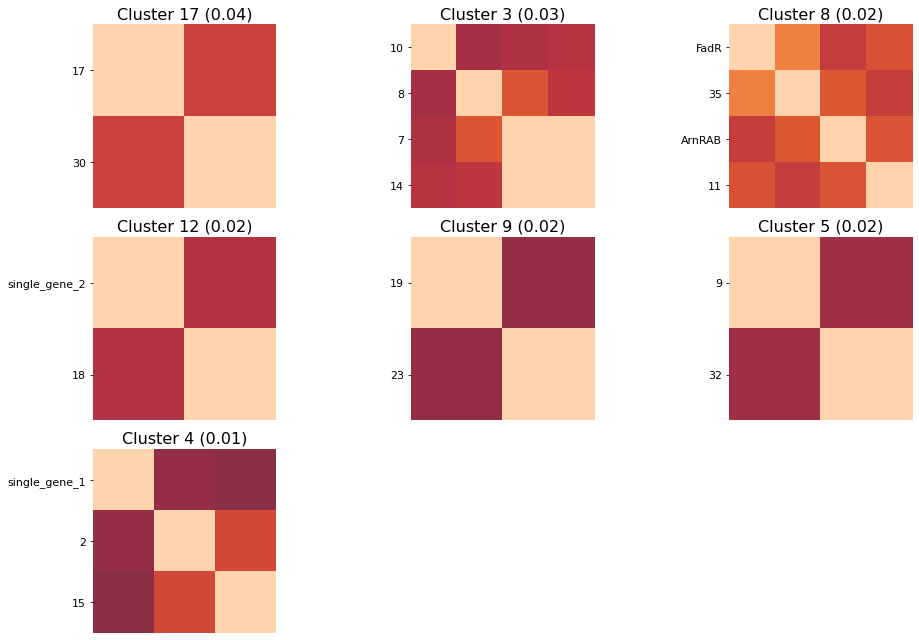

In [35]:
cluster_activities(ica_data,correlation_method='mutual_info',show_best_clusters=True)

You can investigate components with high correlations or mutual information scores to identify interactions between iModulons

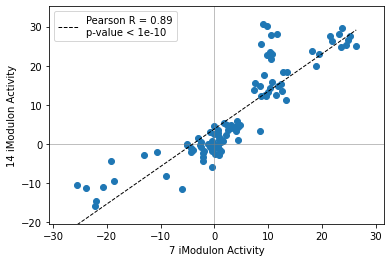

In [36]:
compare_activities(ica_data,7,14)

# Use metadata to automatically characterize iModulons

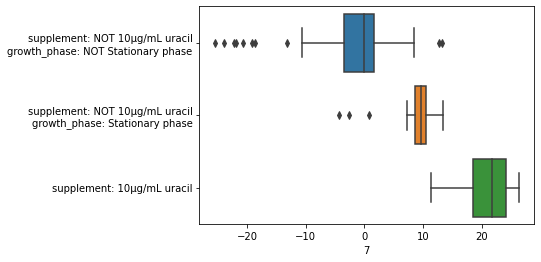

In [37]:
metadata_boxplot(ica_data,7)

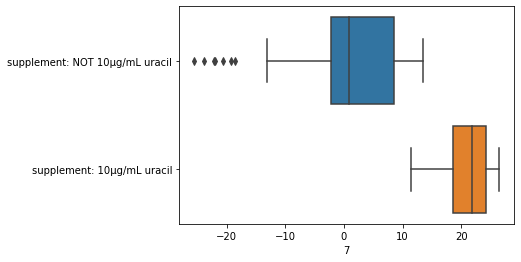

In [38]:
metadata_boxplot(ica_data,7,n_boxes=2)

# Compare against published iModulons
We can use the `compare_ica` function to compare iModulons across different organisms. To do so, you must provide the path to a Bidirection Best Hist CSV between your two organisms of interest.

A Github repository containing many BBH CSV's can be found at the following
link: https://github.com/SBRG/modulome_compare_data/tree/master/bbh_csv

You can also provide a path to your own BBH file, as long as it contains the
columns "**gene**" and "**target**"

See the `Tutorial.ipynb` notebook for more information

In [39]:
from pymodulon.compare import *
from pymodulon.io import *

In [40]:
ecoli_data = load_json_model('../example_data/example.json')

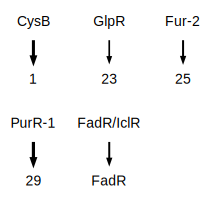

In [41]:
dots,links = compare_ica(ecoli_data.M, ica_data.M, cutoff=0.3,
                         ortho_file = '../example_data/example_bbh.csv')
dots

In the above plot, the top named iModulons are from *E. coli* and the bottom iModulons are from our target organism. Note that the two FadR iModulons are linked together. This `links` variable contains all pairs of iModulons that are linked together

In [42]:
links

[('GlpR', 23, 0.33684973743436064),
 ('PurR-1', 29, 0.6354846418849569),
 ('CysB', 1, 0.6106285375031504),
 ('Fur-2', 25, 0.40297417943147656),
 ('FadR/IclR', 'FadR', 0.3988513646890644)]

In [43]:
for ecoli_mod,target_mod,dist in links:
    ica_data.imodulon_table.loc[target_mod,'ecoli_ortholog'] = ecoli_mod
ica_data.imodulon_table.head()

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene,ecoli_ortholog
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CysB
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
single_gene_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
ArnRAB,ArnR;ArnR1+ArnA;ArnB,1.209743e-19,3.836932e-19,1.0,0.875,0.933333,7.0,7.0,8.0,2.0,NaN,NaN


## Visualize linked iModulons

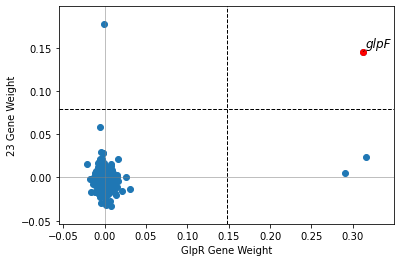

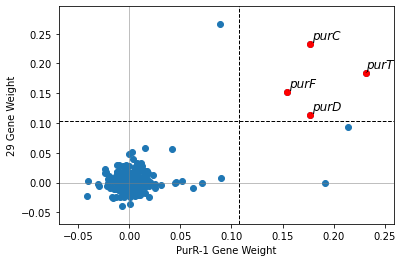

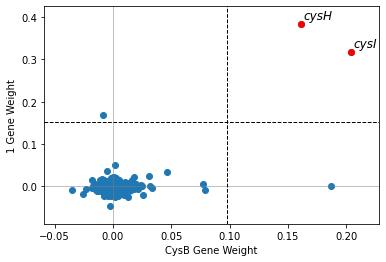

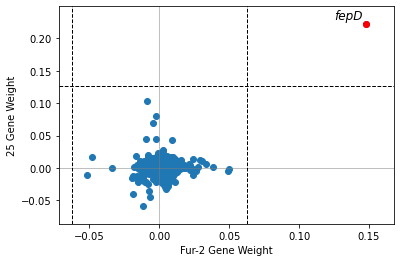

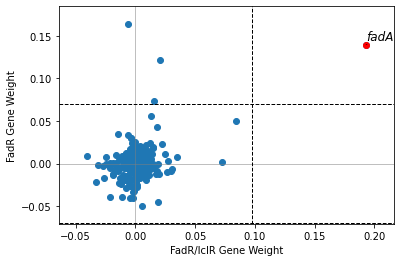

In [47]:
for ecoli_mod,saci_mod,_ in links:
    compare_gene_weights(ica_data = ecoli_data,imodulon1=ecoli_mod,
                         ica_data2 = ica_data,imodulon2=saci_mod,
                         ortho_file='../example_data/example_bbh.csv')

# Save iModulon object

This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [46]:
save_to_json(ica_data,'../example_data/modulome_example/saci.json')

If you prefer to view and edit your iModulon table in excel, save it as a CSV and reload the iModulon as before

In [47]:
ica_data.imodulon_table.to_csv('../example_data/modulome_example/data/iModulon_table.csv')

# Coming soon

1. Saving GO/KEGG enrichments to iModulon table
1. Plotting iModulon gene weights across organisms
1. Using iModulon activities to characterize iModulons
1. Finding motifs using MEME
1. Building iModulonDB web pages
